
# Longformer: Attention with Linear Complexity for Long Sequences

## Introduction to Longformer

Longformer, introduced by Beltagy et al. in 2020, is an efficient attention mechanism designed to handle very long sequences. It addresses the quadratic complexity problem of standard attention by combining two types of attention:
 
1. **Sliding Window Attention**: Each token attends to a fixed-size window of surrounding tokens.
2. **Global Attention**: Selected tokens (e.g., [CLS] token) attend to all tokens and are attended by all tokens.
 
This combination allows Longformer to capture both local and global contexts efficiently, reducing the complexity from O(n^2) to O(n), where n is the sequence length.


In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:

# Our example phrase
phrase = "The quick brown fox jumps over the lazy dog. "
words = phrase.split()
sequence_length = len(words)

# Hyperparameters
batch_size = 1
embedding_dim = 8
num_heads = 2
head_dim = embedding_dim // num_heads
window_size = 3  # Size of the sliding window (on each side)
num_global_tokens = 2  # Number of tokens with global attention

# Create a simple embedding for our words
word_to_idx = {word: idx for idx, word in enumerate(set(words))}
embeddings = torch.randn(len(word_to_idx), embedding_dim)

# Input
X = torch.stack([embeddings[word_to_idx[word]] for word in words]).unsqueeze(0)
print("Input shape:", X.shape)

# Weight matrices
W_q = torch.randn(embedding_dim, embedding_dim)
W_k = torch.randn(embedding_dim, embedding_dim)
W_v = torch.randn(embedding_dim, embedding_dim)
W_o = torch.randn(embedding_dim, embedding_dim)

Input shape: torch.Size([1, 9, 8])


## Longformer Attention Mask
 
The core of Longformer's efficiency comes from its attention mask. This mask combines:
1. A sliding window pattern for local attention
2. Full attention for selected global tokens

Let's implement this mask:


In [15]:
def create_longformer_mask(seq_length, window_size, global_tokens):
    mask = torch.zeros(seq_length, seq_length)

    # Sliding window attention
    for i in range(seq_length):
        start = max(0, i - window_size)
        end = min(seq_length, i + window_size + 1)
        mask[i, start:end] = 1

    # Global attention
    mask[global_tokens, :] = 1
    mask[:, global_tokens] = 1

    return mask

# Create the Longformer mask
global_token_indices = [0, sequence_length // 2]  # First and middle tokens as global
longformer_mask = create_longformer_mask(sequence_length, window_size, global_token_indices)


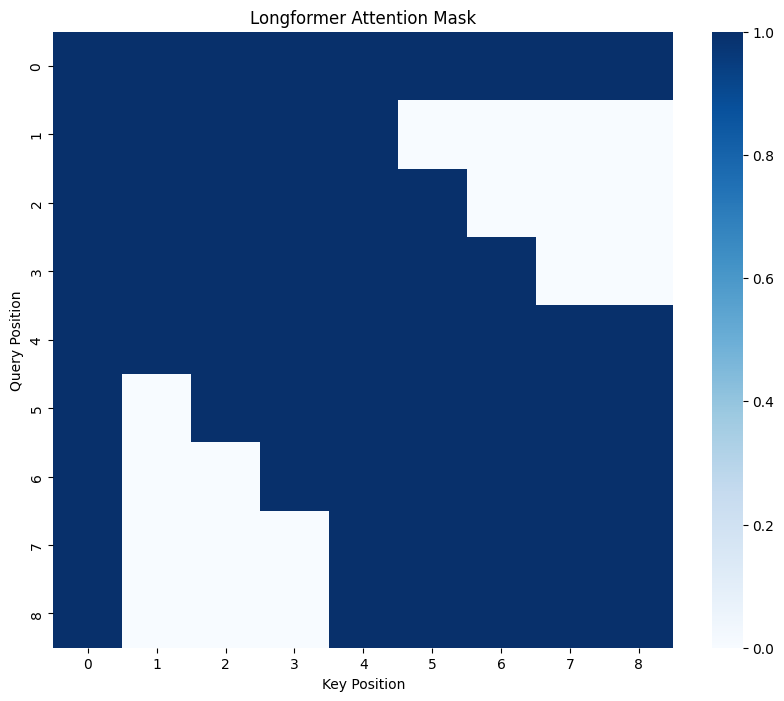

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(longformer_mask, cmap="Blues")
plt.title("Longformer Attention Mask")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

## Compute Q, K, V and Reshape for Multi-head Attention
  
Similar to standard attention, we compute Q, K, and V matrices and reshape them for multi-head attention.


In [17]:
# Calculate Q, K, V matrices
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

# Reshape Q, K, V for multi-head attention
Q = Q.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
K = K.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)

print("Q shape after reshape:", Q.shape)

Q shape after reshape: torch.Size([1, 2, 9, 4])


## Compute Longformer Attention Scores
 
We compute attention scores similarly to standard attention, but apply the Longformer mask to limit which elements each query attends to.


In [18]:
# Calculate attention scores
scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)

# Apply Longformer mask
mask = longformer_mask.unsqueeze(0).unsqueeze(0)
scores = scores.masked_fill(mask == 0, float('-inf'))

print("Attention scores shape:", scores.shape)


Attention scores shape: torch.Size([1, 2, 9, 9])


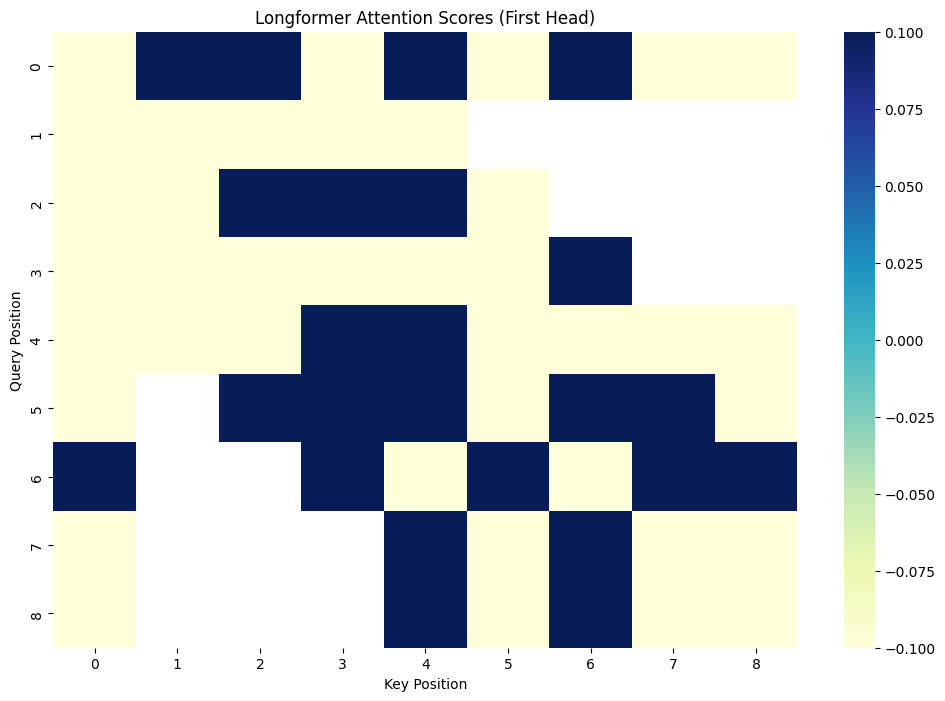

In [19]:
# Visualize attention scores for the first head
plt.figure(figsize=(12, 8))
sns.heatmap(scores[0, 0].detach().numpy(), cmap="YlGnBu")
plt.title("Longformer Attention Scores (First Head)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()


## Apply Softmax to Get Attention Weights
 
We apply softmax to the scores to get the attention weights. This step is identical to standard attention, but operates only on the non-masked elements.


Attention weights shape: torch.Size([1, 2, 9, 9])


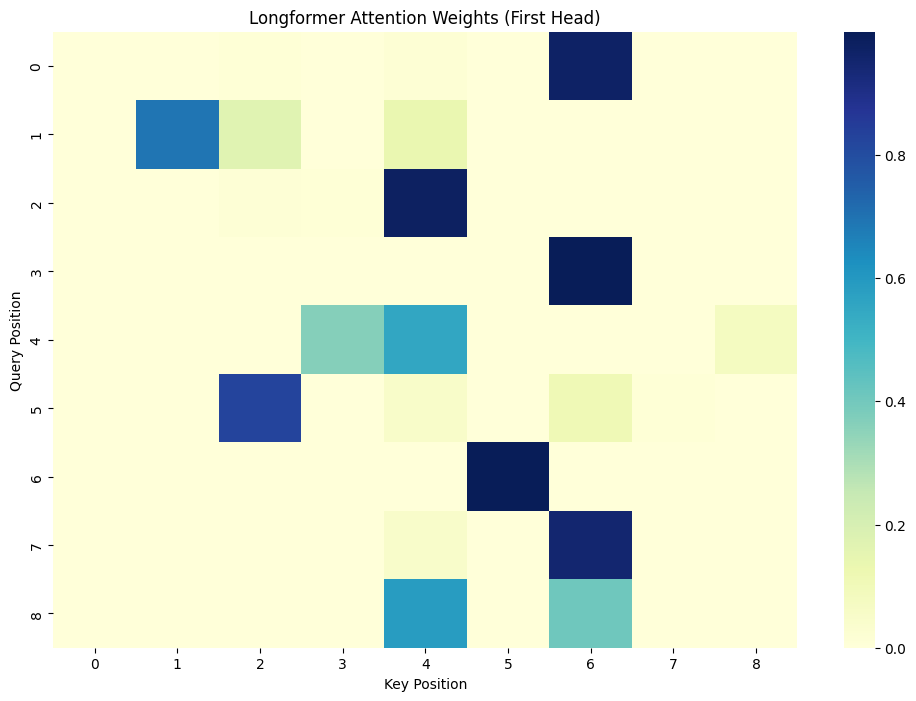

In [20]:
# Apply softmax to get attention weights
attn_weights = F.softmax(scores, dim=-1)

print("Attention weights shape:", attn_weights.shape)

# Visualize attention weights for the first head
plt.figure(figsize=(12, 8))
sns.heatmap(attn_weights[0, 0].detach().numpy(), cmap="YlGnBu")
plt.title("Longformer Attention Weights (First Head)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

## Compute Attention Output
 
We apply the attention weights to the Values. This step is similar to standard attention, but uses the Longformer attention weights.


In [21]:
# Apply attention weights to values
attn_output = torch.matmul(attn_weights, V)

print("Attention output shape:", attn_output.shape)


Attention output shape: torch.Size([1, 2, 9, 4])


## Reshape and Project Output
  
Finally, we reshape the attention output and apply the output projection. This step is identical to standard attention.


In [22]:
# Reshape and project output
attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, sequence_length, embedding_dim)
output = torch.matmul(attn_output, W_o)

print("Final output shape:", output.shape)


Final output shape: torch.Size([1, 9, 8])


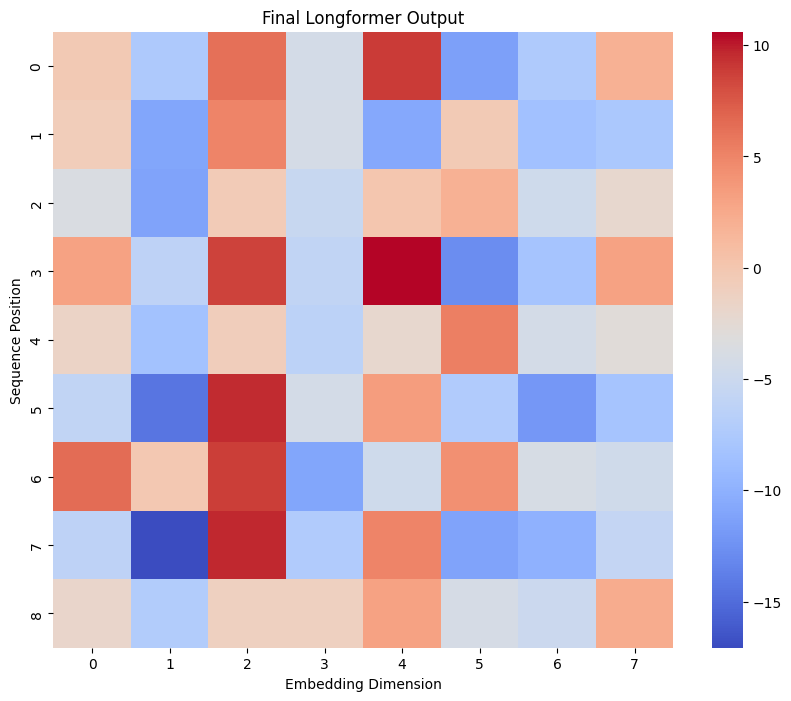

In [23]:
# Visualize final output
plt.figure(figsize=(10, 8))
sns.heatmap(output[0].detach().numpy(), cmap="coolwarm")
plt.title("Final Longformer Output")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence Position")
plt.show()

## Comparison with Standard Attention


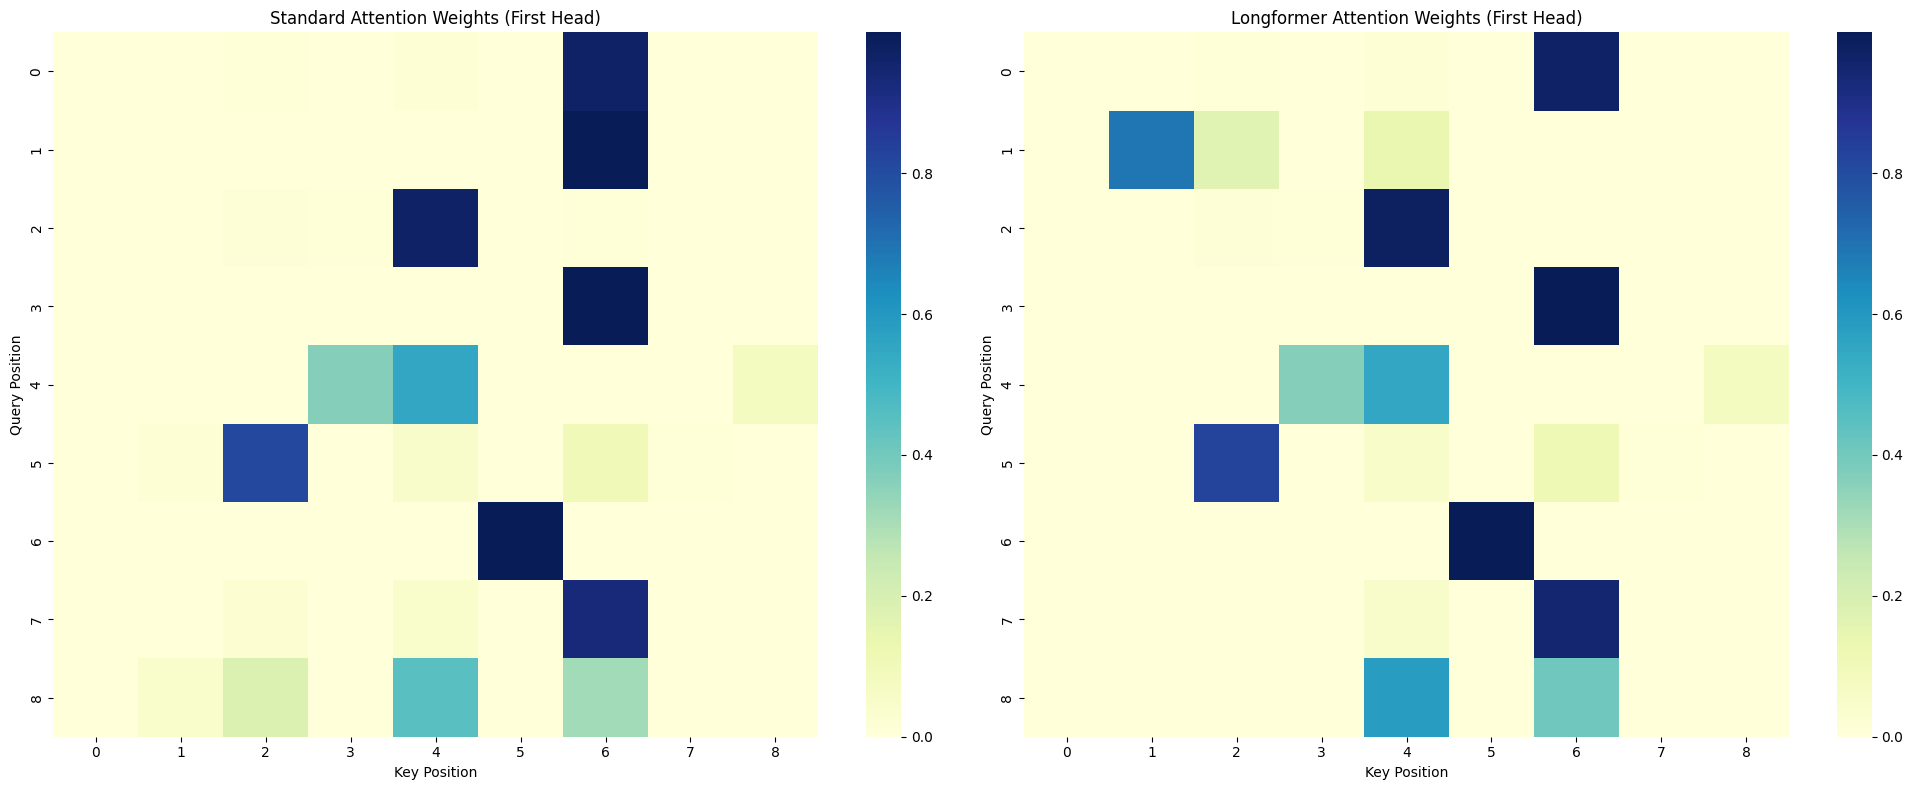

In [24]:
def standard_attention(Q, K, V):
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)
    attn_weights = F.softmax(scores, dim=-1)
    return attn_weights, torch.matmul(attn_weights, V)

# Compute standard attention weights
std_attn_weights, _ = standard_attention(Q, K, V)

# Visualize standard vs Longformer attention
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(std_attn_weights[0, 0].detach().numpy(), ax=ax1, cmap="YlGnBu")
ax1.set_title("Standard Attention Weights (First Head)")
ax1.set_xlabel("Key Position")
ax1.set_ylabel("Query Position")

sns.heatmap(attn_weights[0, 0].detach().numpy(), ax=ax2, cmap="YlGnBu")
ax2.set_title("Longformer Attention Weights (First Head)")
ax2.set_xlabel("Key Position")
ax2.set_ylabel("Query Position")

plt.tight_layout()
plt.show()

## Conclusion
 
Longformer achieves linear complexity by combining sliding window attention with global attention on specific tokens. 
This allows it to handle extremely long sequences efficiently, while still maintaining the ability to capture both 
local and global contexts.

Key observations from our visualizations:
 
1. The Longformer attention mask clearly shows the sliding window pattern and global attention tokens.
2. The attention weights in Longformer are sparse, focusing on local context and global tokens.
3. Despite the sparsity, Longformer still captures meaningful attention patterns, as seen in the comparison with standard attention.

Advantages of Longformer:
1. Linear time and space complexity, allowing for processing of very long sequences.
2. Ability to capture both local and global contexts efficiently.
3. Flexible attention pattern that can be adapted to different tasks.

Limitations of Longformer:
1. The fixed window size may not be optimal for all types of data or tasks.
2. The selection of global attention tokens can impact performance and may require task-specific tuning.
3. Implementation can be more complex than standard attention, especially for efficient sparse operations.

Longformer represents a significant advancement in efficient attention mechanisms, especially for tasks involving 
very long sequences such as document-level NLP tasks or long-form question answering. Its ideas continue to influence 
research in this area and have been applied in various domains beyond natural language processing.